## TSP heuristics

### Problem Summary

The goal is to propose a set of plausible decision-making heurstics for choosing a path in a TSP, and then to evaluate them in some useful way against actual human choices.

This is a crack at that problem.

Here, I frame heuristics as functions that give a probability distribution over all choices.
Heuristic functions take

1. a set of unvisited points (in the order they will be visited, in case a heuristic needs to 'see the future')
2. an ordered list of visited points  
3. optionally, any other information needed for calculation

For all univisited points, the function yields a calculated transitional probability. All visited points are given a probability of 0.

In this way, each heuristic gives a vector of transitional probabilities, which can be concatenated into a matrix.

Given n heuristics, there is a separate "weight vector" of length n, which is multiplied by the heuristics matrix. The transitional probability for each point is then found by summing the weighted probability for that point given by each heuristic.

JAGS is used to calculate the values of the weight vector, by regarding the actual nth point visited as being drawn from a categorical distribution with probabilites equal to the summed weighted heuristics.



In [4]:
import pjbcma
import matplotlib.pyplot as plt
# import pandas as pd
from math import sqrt

Data import:

In [5]:
# load problem 1, a 30 city TSP
p1coords = []
with open('tsp30.1.csv', 'r') as file:
    for index, line in enumerate(file.readlines()):
        p1coords.append(tuple((float(coord) for coord in line.split(","))))



# load all n = 82 paths through this TSP        
p1paths=[]
with open('tsp30tours.csv', 'r') as file:
    for index, line in enumerate(file.readlines()):
        p1paths.append([int(item) for index, item in enumerate(line.split(",")) if index%9==0])
        
p1paths = list(zip(*[p1paths[i] for i in range(len(p1paths))]))



In [6]:
#turn a list of coords and a list of paths into a list of ordered coords.
paths = []

for subject in range(len(p1paths)):
    order = {item:index for index, item in enumerate(p1paths[subject])}
    pathlist = list(zip(p1coords, range(1,31)))
    pathlist.sort(key=lambda x : order[x[1]])
    pathlist = [i[0] for i in pathlist]
    paths.append(pathlist)

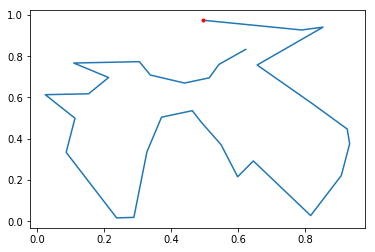

In [13]:


#verify paths were loaded correctly

p_num = 3
x, y = paths[0][p_num]

ax = plt.plot([point[0] for point in paths[p_num]],[point[1] for point in paths[p_num]])
plt.plot([x], [y], marker='o', markersize=3, color="red")

In [14]:
#convert to jags-acceptable format 
def coords2data(coords):
    return [item for pair in coords for item in pair]

In [15]:
datapaths = [coords2data(path) for path in paths]

In [6]:
#pjbcma.pyjags.modules.unload_module("TSPH")

In [16]:
pjbcma.pyjags.modules.get_modules_dir()
pjbcma.pyjags.modules.load_module("TSPH", modules_dir='/usr/local/lib/x86_64-linux-gnu/JAGS/modules-4')

In [19]:
## PJBCMA DEMO:
# Copy-paste this entire output into an ipython notebook cell
# and run the cell to sample from and analyze a very basic
# JAGS model.
# For more advanced usage options, check out the examples
# in the `Using pjbcmassistant for Bayesian modeling` notebook
# at https://github.com/icushman/pjbcm-assistant

spec_string = """
model: #model code or local .txt file
var totalProbs[nSubjects, problemLength,problemLength];
model{

    for (j in 1:nSubjects) {
        for (i in 1:(problemLength-1)) {
            prox[j,i,1:problemLength] <- proximity(i, problemLength, myData[j,1:60])
            heur2[j,i,1:problemLength] <- heuristic2(i, problemLength, myData[j,1:60])
            
            totalProbs[j,i,1:problemLength] <- hweight[1]*prox[j,i,1:problemLength] +
                                               hweight[2]*heur2[j,i,1:problemLength]
            
            mychoices[j,i+1] ~ dcat(totalProbs[j,i,1:problemLength])
           #mychoices[j,i] ~ dcat(c(1,2,3,4))
        }
        
        }
        

        weightPrior <- c(1,1)
        hweight[1:nheuristics] ~ ddirich(weightPrior[1:nheuristics])
    
        


        
        

}

settings:
chains = 4 #number of chains to run
samples = 100 #number of samples per chain
thinning = 0 #number of samples to discard between recorded samples
burnin = 500 #number of burn-in samples per chain
adapt = auto #integer or 'auto'. pjbcma.SimpleSampler uses 'auto' to adapt until optimal.
seed = random #optionally set to number to fix seed (Mersenne-Twister)

data:

myData = [1,2,3,4,5,6,7,8]# can be integer or list
problemLength = len(myData)/2
#mychoices = [1,2,3,4,5]
nheuristics = 2
nSubjects = 2
#observationCount = 3 # variables can be assigned using Python expressions

sample: #model variables to record, one per line
#prox
#heur2
#totalProbs
hweight
"""

sampler = pjbcma.SimpleSampler(spec_string)

## optionally set data from outside the spec string

nSubjects = 82
#mycoords = s1p130#[(0,0),(0,1),(1,0),(1,1)]
mychoices = [[i+1 for i in range(30)] for _ in range(nSubjects)]
sampler.set_data("myData", datapaths)#[paths[0:nSubjects])
#sampler.set_data("myData", paths[0]) #working data sample
sampler.set_data("problemLength", 30)
sampler.set_data("mychoices", mychoices)
# sampler.set_data("observationCount", 8)

#take samples
samples = sampler.sample()

#see documentation for all visualization options

#samples.vizchains("prox_2")
samples.summarize()

adapting: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
Burn-in iterations (no samples recorded):
sampling: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
Sample iterations:
sampling: iterations 400 of 400, elapsed 0:00:00, remaining 0:00:00


,mean,std dev,median,mode,HPD,95CI
hweight_0,0.959473,0.033681,0.965441,0.99886,"[0.898, 1.0]","[0.881, 1.0]"
hweight_1,0.040527,0.033681,0.034559,0.00114,"[0.0, 0.102]","[0.0, 0.119]"


# End of clean code

In [21]:
summary = samples.summarize()

In [171]:
## PJBCMA DEMO:
# Copy-paste this entire output into an ipython notebook cell
# and run the cell to sample from and analyze a very basic
# JAGS model.
# For more advanced usage options, check out the examples
# in the `Using pjbcmassistant for Bayesian modeling` notebook
# at https://github.com/icushman/pjbcm-assistant

spec_string = """
model: #model code or local .txt file
var totalProbs[problemLength,problemLength];
model{


        for (i in 1:(problemLength-1)) {
            prox[i,1:problemLength] <- proximity(i, problemLength, myData)
            heur2[i,1:problemLength] <- heuristic2(i, problemLength, myData)
            
            totalProbs[i,1:problemLength] <- hweight[1]*prox[i,1:problemLength] +
                                            hweight[2]*heur2[i,1:problemLength]
            
            mychoices[i+1] ~ dcat(totalProbs[i,1:problemLength])
           #mychoices[j,i] ~ dcat(c(1,2,3,4))
        }
        

        
        for (i in 1:nheuristics) {
            hweight[i] ~ dunif(0,1)
        }
        


        
        

}

settings:
chains = 2 #number of chains to run
samples = 10000 #number of samples per chain
thinning = 0 #number of samples to discard between recorded samples
burnin = 500 #number of burn-in samples per chain
adapt = auto #integer or 'auto'. pjbcma.SimpleSampler uses 'auto' to adapt until optimal.
seed = random #optionally set to number to fix seed (Mersenne-Twister)

data:

myData = [1,2,3,4,5,6,7,8]# can be integer or list
problemLength = len(myData)/2
#mychoices = [1,2,3,4,5]
nheuristics = 2
#nSubjects = 2
#observationCount = 3 # variables can be assigned using Python expressions

sample: #model variables to record, one per line
#mu
#prox
#heur2
#totalProbs
hweight
#mychoices
"""

sampler = pjbcma.SimpleSampler(spec_string)

## optionally set data from outside the spec string

nSubjects = 1
mycoords = s1p130#[(0,0),(0,1),(1,0),(1,1)]
mychoices = [index+1 for index, value in enumerate(mycoords)]
# sampler.set_data("myData", paths[0:nSubjects])
sampler.set_data("myData", datapaths[0]) #working data sample
sampler.set_data("problemLength", 30)
sampler.set_data("mychoices", mychoices)
# sampler.set_data("observationCount", 8)

#take samples
samples = sampler.sample()

#see documentation for all visualization options

#samples.vizchains("prox_2")
#samples.summarize()

adapting: iterations 1000 of 1000, elapsed 0:00:00, remaining 0:00:00
Burn-in iterations (no samples recorded):
sampling: iterations 1000 of 1000, elapsed 0:00:00, remaining 0:00:00
Sample iterations:
sampling: iterations 20000 of 20000, elapsed 0:00:03, remaining 0:00:00


In [172]:
samples.summarize()
#samples.samples

,mean,std dev,median,mode,HPD,95CI
hweight_0,0.666440,0.234395,0.706951,0.945291,"[0.226, 1.0]","[0.161, 0.986]"
hweight_1,0.071634,0.082059,0.043636,0.003790,"[0.0, 0.237]","[0.001, 0.299]"


In [ ]:
paths[0:1]

In [ ]:
samples.samples

In [12]:
 len(paths[0:nSubjects][0])

60

In [ ]:
mychoices

In [ ]:
x.loc['hweight_1']['mean']/x.loc['hweight_0']['mean']

In [ ]:
x.loc['heur2_0_1']

In [ ]:
x.loc['prox_0_20']

In [ ]:
x

In [ ]:
s1p130

In [ ]:
samples.vizchains('hweight_0','hweight_1')

In [ ]:
mychoices

In [ ]:
samples.samples

In [ ]:
## PJBCMA DEMO:
# Copy-paste this entire output into an ipython notebook cell
# and run the cell to sample from and analyze a very basic
# JAGS model.
# For more advanced usage options, check out the examples
# in the `Using pjbcmassistant for Bayesian modeling` notebook
# at https://github.com/icushman/pjbcm-assistant

spec_string = """
model: #model code or local .txt file
model{

    for (subject in 1:nsubjects) {
        for (i in 1:(problemLength-1)) {
            prox[subject,i,1:problemLength] <- proximity(i, problemLength, data[subject])
            heur2[subject,i,1:problemLength] <- heuristic2(i, problemLength, data[subject])
            
            totalProbs[subject,i,1:problemLength] <-hweight[1]*prox[i,1:problemLength] +
                                            hweight[2]*heur2[i,1:problemLength]
            
            mychoices[subject,i+1] ~ dcat(totalProbs[i,1:problemLength])
           #mychoices[i] ~ dcat(c(1,2,3,4))
        }
        
        }
        
        for (i in 1:nheuristics) {
            hweight[i] ~ dunif(0,1)
        }
        
        
        

}

settings:
chains = 2 #number of chains to run
samples = 10000 #number of samples per chain
thinning = 0 #number of samples to discard between recorded samples
burnin = 500 #number of burn-in samples per chain
adapt = auto #integer or 'auto'. pjbcma.SimpleSampler uses 'auto' to adapt until optimal.
seed = random #optionally set to number to fix seed (Mersenne-Twister)

data:

data = [1,2,3,4,5,6,7,8]# can be integer or list
problemLength = 2
mychoices = [1,2,3,4,5]
nheuristics = 2
nsubjects = 0
#observationCount = 3 # variables can be assigned using Python expressions

sample: #model variables to record, one per line
#mu
#prox
#heur2
#totalProbs
hweight
"""

sampler = pjbcma.SimpleSampler(spec_string)

## optionally set data from outside the spec string

nsubjects = 2
mycoords = s1p130#[(0,0),(0,1),(1,0),(1,1)]
mychoices = [index+1 for index, value in enumerate(mycoords)]
sampler.set_data("data", paths[0:nsubjects])
sampler.set_data("nsubjects", nsubjects)
sampler.set_data("problemLength", len(mycoords))
sampler.set_data("mychoices", mychoices)
# sampler.set_data("observationCount", 8)

#take samples
samples = sampler.sample()

#see documentation for all visualization options

#samples.vizchains("prox_2")
samples.summarize()

In [144]:
## PJBCMA DEMO:
# Copy-paste this entire output into an ipython notebook cell
# and run the cell to sample from and analyze a very basic
# JAGS model.
# For more advanced usage options, check out the examples
# in the `Using pjbcmassistant for Bayesian modeling` notebook
# at https://github.com/icushman/pjbcm-assistant

spec_string = """
model: #model code or local .txt file
model{

        for (i in 1:ndata) {
            mydata[i] ~ dcat(pi)
        }
        
        pi <- c(a,b,c,d)
        a <- 0
        b ~ dunif(0,1)
        c ~ dunif(0,1)
        d ~ dunif(0,1)

}

settings:
chains = 4 #number of chains to run
samples = 10000 #number of samples per chain
thinning = 0 #number of samples to discard between recorded samples
burnin = 500 #number of burn-in samples per chain
adapt = auto #integer or 'auto'. pjbcma.SimpleSampler uses 'auto' to adapt until optimal.
seed = random #optionally set to number to fix seed (Mersenne-Twister)

data:
mydata = [1,2,3,4]
ndata = len(mydata)
#observationCount = 3 # variables can be assigned using Python expressions

sample: #model variables to record, one per line
pi

"""

sampler = pjbcma.SimpleSampler(spec_string)

## optionally set data from outside the spec string
# sampler.set_data('mydata', [1 for i in range(1000)])
# sampler.set_data('ndata', 1000)
#take samples
samples = sampler.sample()

#see documentation for all visualization options

#samples.vizchains("prox_2")
samples.summarize()

JagsError: Error in node mydata[1]
Node inconsistent with parents


In [61]:
s1p130.sort(key=lambda x : order[x[1]])

In [35]:
s1p130.sort(key=(lambda x : x[1]))



In [62]:
s1p130 

[((0.7894, 0.927), 15),
 ((0.6567, 0.7573), 19),
 ((0.6224, 0.8328), 18),
 ((0.4954, 0.9741), 13),
 ((0.5427, 0.7604), 25),
 ((0.5136, 0.6952), 30),
 ((0.4397, 0.67), 10),
 ((0.3378, 0.7087), 22),
 ((0.3048, 0.7735), 28),
 ((0.2129, 0.6968), 16),
 ((0.1088, 0.7669), 2),
 ((0.1533, 0.618), 11),
 ((0.0238, 0.6136), 1),
 ((0.1125, 0.4996), 12),
 ((0.0861, 0.3345), 4),
 ((0.237, 0.0169), 8),
 ((0.2884, 0.0195), 24),
 ((0.3274, 0.3365), 14),
 ((0.371, 0.5046), 29),
 ((0.463, 0.5362), 23),
 ((0.4893, 0.4814), 21),
 ((0.549, 0.3713), 3),
 ((0.5985, 0.2163), 5),
 ((0.6454, 0.2927), 9),
 ((0.8166, 0.0282), 7),
 ((0.9082, 0.2222), 17),
 ((0.9331, 0.3756), 26),
 ((0.9258, 0.4472), 20),
 ((0.8208, 0.5711), 6),
 ((0.8535, 0.9406), 27)]

In [63]:
s1p130 = [i[0] for i in s1p130]

In [64]:
s1p130

[(0.7894, 0.927),
 (0.6567, 0.7573),
 (0.6224, 0.8328),
 (0.4954, 0.9741),
 (0.5427, 0.7604),
 (0.5136, 0.6952),
 (0.4397, 0.67),
 (0.3378, 0.7087),
 (0.3048, 0.7735),
 (0.2129, 0.6968),
 (0.1088, 0.7669),
 (0.1533, 0.618),
 (0.0238, 0.6136),
 (0.1125, 0.4996),
 (0.0861, 0.3345),
 (0.237, 0.0169),
 (0.2884, 0.0195),
 (0.3274, 0.3365),
 (0.371, 0.5046),
 (0.463, 0.5362),
 (0.4893, 0.4814),
 (0.549, 0.3713),
 (0.5985, 0.2163),
 (0.6454, 0.2927),
 (0.8166, 0.0282),
 (0.9082, 0.2222),
 (0.9331, 0.3756),
 (0.9258, 0.4472),
 (0.8208, 0.5711),
 (0.8535, 0.9406)]

In [85]:
def distance(p1,p2):
    return sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

In [87]:
1.4143 - distance(s1p130[0],s1p130[1])

1.1988762780007733

In [76]:
c1 = coords2data(s1p130)